# Proof of concept
This notebook shows how the naive application of compression techniques can lead to reductions in parameters and model size, without significant loss in accuracy.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import torch
import importlib
import inspect
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn

# Add thesis package to path
sys.path.append("../")

import src.general as general
import src.evaluation as eval
import src.metrics as metrics
import src.plot as plot


### Loading a model
Models can be loaded by providing a model state file and a model class file.

The model state file can be loaded from a ``.pt`` file, or from a ``.pth`` file. It contains the model's state dictionary, which contains the model's parameters.

The model class file can be loaded from a ``.py`` file. It contains a class that inherits from ``torch.nn.Module`` and implements the model architecture.

The tool should work with every model that is supported by PyTorch. 
The ``/models/`` folder contains a few models that can be used for testing.

In [3]:
model_state = "../models/mnist.pt"
model_class = "models.mnist"

# Import the module classes
module = importlib.import_module(model_class)
classes = general.get_module_classes(module)
for cls in classes:
    globals()[cls.__name__] = cls

# Get device
device = general.get_device()

# Load the model
model = torch.load(model_state, map_location=torch.device(device))

Using cuda: False


### Loading dataset

In [4]:
# Load MNIST dataset
batch_size = 8
test_batch_size = 1000
use_cuda = False

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
mnist_transform = transforms.ToTensor()
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=mnist_transform,),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=mnist_transform,),
    batch_size=test_batch_size, shuffle=True, **kwargs)


Analyzing the dataset

torch.Size([8, 1, 28, 28])
torch.Size([8])


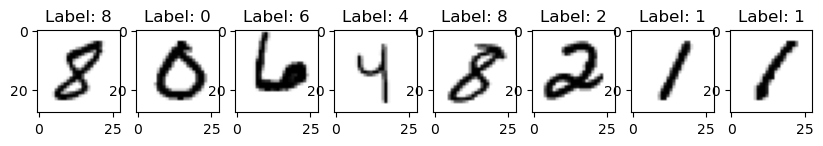

In [5]:
# Get size of element from train_loader
input_batch = next(iter(train_loader))
print(input_batch[0].size()) # Images
print(input_batch[1].size()) # Labels

# Plot all images in batch horizontally next to each other
fig, ax = plt.subplots(1, batch_size, figsize=(10, 10))
for i in range(batch_size):
    ax[i].imshow(input_batch[0][i].numpy().squeeze(), cmap='gray_r')
    ax[i].set_title("Label: {}".format(input_batch[1][i].numpy()))
plt.show()

### Evaluating model before compression
We measure the model's relevant properties such as number of parameters, model size, and number of FLOPs. 
We also measure the accuracy on the test set before compression. 

Calculating the number of FLOPS is not solely dependent on the model. It depends on the model's input size, which depends on the dataset. 
A model's input size is not always fixed. For example, a linear layer has a fixed input size, but a convolutional layer does not.

In [6]:
criterion = F.nll_loss

loss, score, duration, batch_duration, data_duration = general.test(model, device, test_loader, criterion, metric=metrics.accuracy)

Test: 100%|██████████| 60/60 [00:04<00:00, 12.88it/s]

================================ TEST PERFORMANCE ==============================
Average loss = 0.0174
Accuracy = 0.9949
Elapsed time = 4687.57 milliseconds (78.13 per batch, 0.08 per data point)


In [7]:
input_batch = next(iter(train_loader))
example_input = input_batch[0][0]

In [8]:
evaluation_metrics = {
    "loss": loss,
    "score": score,
    "duration": duration,
    "batch_duration": batch_duration,
    "data_duration": data_duration,
    "model": model,
    "batch_size": batch_size,
    "example_input": example_input,
}

plot.print_metrics(**evaluation_metrics)


==================================== METRICS ===================================
Loss: 0.017443
Score: 0.994850
Time per batch: 78.1261 ms (8 per batch)
Time per data point: 0.0781 ms
Model Size: 1.65 MB
Number of parameters: 431080
Number of FLOPS: 2.30772M


## Pruning
In this proof of concept we use a simple magnitude pruning technique.

### Magnitude Pruning

In [9]:
import torch.nn.utils.prune as prune
# Define the parameters to prune
parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.99,
)

Test again after pruning.

In [10]:
test_loss, test_score, duration, batch_duration, data_duration = general.test(model, device, test_loader, criterion=torch.nn.CrossEntropyLoss())

Test: 100%|██████████| 60/60 [00:04<00:00, 13.03it/s]

================================ TEST PERFORMANCE ==============================
Average loss = 1.9867
Elapsed time = 4605.73 milliseconds (76.76 per batch, 0.08 per data point)


In [11]:
evaluation_metrics_after_pruning = {
    "loss": test_loss,
    "score": test_score,
    "duration": duration,
    "batch_duration": batch_duration,
    "data_duration": data_duration,
    "batch_size": batch_size,
    "model": model,
}
plot.print_before_after_metrics(before=evaluation_metrics, after=evaluation_metrics_after_pruning)

============================= METRICS BEFORE & AFTER ===========================
Loss: 0.017443 -> 1.986651
Score: 0.994850 -> 0.000000 
Time per batch: 78.1261 ms -> 76.7622 ms (8 per batch)
Time per data point: 0.0781 ms -> 0.0768 ms
Model Size: 3.29 MB -> 3.29 MB
Number of parameters: 431080 -> 431080


Attrbibution scores from TorchPruner.

In [18]:
from torchpruner.attributions import RandomAttributionMetric  # or any of the methods above

attr = RandomAttributionMetric(model, train_loader, criterion, device)
for module in model.children():
    if len(list(module.children())) == 0:  # leaf module
        scores = attr.run(module)
        print(module)
        print (len(scores), "scores")
        print(scores
    )


Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
20 scores
[0.90556907 0.7308574  0.77896372 0.53220348 0.38809771 0.19996281
 0.71886207 0.3240958  0.51121534 0.60820147 0.35363184 0.29241178
 0.2549905  0.72543876 0.84186232 0.77032081 0.4864856  0.32348744
 0.02686406 0.05674287]
Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
50 scores
[0.1009653  0.61312537 0.03682574 0.01213523 0.98413907 0.36686641
 0.48976058 0.65272271 0.83006874 0.32946849 0.79581497 0.46061219
 0.55017495 0.34058537 0.26632958 0.96184296 0.24255674 0.06916202
 0.5137071  0.89733883 0.35586382 0.77523945 0.98485653 0.30455847
 0.13413109 0.87196475 0.61127909 0.40886228 0.92706534 0.70146027
 0.46644257 0.21170544 0.43075024 0.55954722 0.27424957 0.47469231
 0.32329757 0.85011913 0.51963496 0.5540554  0.92746807 0.3656339
 0.09642605 0.36178719 0.0585024  0.01870594 0.94048332 0.73576159
 0.69291318 0.90148215]
Linear(in_features=800, out_features=500, bias=True)
500 scores
[0.53990195 0.44003941 0.60919331

In [13]:
tuple(example_input.shape)

(1, 28, 28)

In [20]:
from torchinfo import summary

batch_size = 16
summary(model, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MnistModel                               [16, 10]                  --
├─Conv2d: 1-1                            [16, 20, 24, 24]          410
├─Conv2d: 1-2                            [16, 50, 8, 8]            1,996
├─Linear: 1-3                            [16, 500]                 864
├─Linear: 1-4                            [16, 10]                  1,615
Total params: 4,885
Trainable params: 4,885
Non-trainable params: 0
Total mult-adds (M): 5.86
Input size (MB): 0.05
Forward/backward pass size (MB): 1.95
Params size (MB): 0.02
Estimated Total Size (MB): 2.02

In [67]:
from torchpruner.pruner import (Pruner)
from torchpruner.attributions import ShapleyAttributionMetric


# Define prunable layers
layers = list(model.children())
# print(layers)
prunable_layers = [
    # (module_to_prune -> [modules_for_cascading_pruning])
    # (layers[1], layers[2:4]),
    (layers[2], [layers[3]]),
]

input_size = tuple(example_input.shape)

pruner = Pruner(model, input_size, device)
# attribution = ShapleyAttributionMetric(model, test_loader, criterion, device, sv_samples=1)
attribution = RandomAttributionMetric(model, test_loader, criterion, device)
    
from torch.nn.modules.conv import _ConvNd
SUPPORTED_OUT_PRUNING_MODULES = [nn.Linear, _ConvNd]


# Prune layers starting from the outermost
for module, cascading_modules in prunable_layers[::-1]:
    print(module.__class__)
    print(any(isinstance(module, t) for t in SUPPORTED_OUT_PRUNING_MODULES))
    # Compute Shapley Value attributions
    print("Start attribution computations")

    attr = attribution.run(module)[0]
    print("Attributions computed")
    # Select indices corresponding to negative attributions
    pruning_indices = np.argwhere(attr < 0).flatten()
    # Perform pruning
    print("Start pruning")
    pruner.prune_model(module, pruning_indices, cascading_modules=cascading_modules)

<class 'torch.nn.modules.linear.Linear'>
True
Start attribution computations
Attributions computed
Start pruning
Forward pass to record nans
Pruning model...
Pruning 0 units from Linear(in_features=800, out_features=500, bias=True) (out)


In [61]:
attr

0.0

In [ ]:
# Test final model
summary(model, input_size=input_size, device=device.type)
general.test(model, device, test_loader, criterion)

In [15]:

pruner = Pruner(model, input_size=tuple(example_input.shape), device=device)
pruner.prune_model(nn.Linear, indices=[1,2], cascading_modules=[])

TypeError: register_forward_hook() missing 1 required positional argument: 'hook'